In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union, nearest_points

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
style.use('default')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [3]:
# Place                                Country              CRS
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:2062

# for writing the street network to the DXF file
# local_crs needs to be projected, with X and Y (and not E and N) cartesian coordinates
# e.g. EPSG:25830 does not work, EPSG:2062 does work

place_name = 'Barcelona'
local_crs = 'EPSG:2062'
buffer = 800

In [4]:
# nodes within a tolerance value (meters) from each other will be simplified into one
simplification_tolerance = 15

In [5]:
folder = os.path.expanduser('~/confidential/cohort')

# Load and pre-process data

## Place 

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)

In [7]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

## Load and simplify street network

In [8]:
# all roads suitable for pedestrians
G = ox.graph_from_polygon(extent_shape, network_type='walk', retain_all=True)
paths = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)

In [9]:
#  project the network and simplify it based on the tolerance value chosen
G_proj = ox.project_graph(G, to_crs=local_crs)
G_simpl = ox.consolidate_intersections(
    G_proj, rebuild_graph=True, tolerance=simplification_tolerance, 
    dead_ends=True, reconnect_edges=True)

In [10]:
print("After consolidating intersections (tolerance {}), {} out of {} nodes remain ({} %).".format(simplification_tolerance, len(G_simpl), len(G), (round(100*len(G_simpl)/len(G), 1))))

After consolidating intersections (tolerance 15), 13842 out of 79322 nodes remain (17.5 %).


In [11]:
paths_simpl = ox.utils_graph.graph_to_gdfs(G_simpl, nodes=False, edges=True).to_crs(local_crs)
paths_simpl.reset_index(drop=True, inplace=True)

In [12]:
nodes_simpl = ox.utils_graph.graph_to_gdfs(G_simpl, nodes=True, edges=False).to_crs(local_crs)
nodes_simpl.reset_index(drop=True, inplace=True)

## Load and simplify geocoordinates

In [13]:
sub_folder = 'preprocessed'
filename = 'BREATHE_preprocessed.csv'

In [14]:
# read the geocoordinates, and convert to right CRS and clip to place boundaries
# (i.e. matching with the street network collected)
df = pd.read_csv(os.path.join(folder, sub_folder, filename), delimiter=',', engine='python')
df.geometry = gpd.GeoSeries.from_wkt(df.geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:25831')
gdf = gdf.to_crs(local_crs)
gdf = gpd.clip(gdf, place)

In [15]:
# children's homes are commute origins, store their coordinates as attributes
origins = gdf[gdf['type']==1].copy()
origins['X'] = origins.geometry.x
origins['Y'] = origins.geometry.y

In [16]:
# children's schools are commute destinations, store their coordinates as attributes
destinations = gdf[gdf['type']==2].copy()
destinations['X'] = destinations.geometry.x
destinations['Y'] = destinations.geometry.y

## Plot

In [17]:
# create legend
input_legend_handles = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, alpha=0.8, label='Home (origin)'),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, alpha=0.8, label='School (destination)'),
    mlines.Line2D([], [], color='#404040', linestyle='-', linewidth=3, label='Pedestrian road network'),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
]

Please note plotting of actual BREATHE home, school, and commuting route locations is commented out.

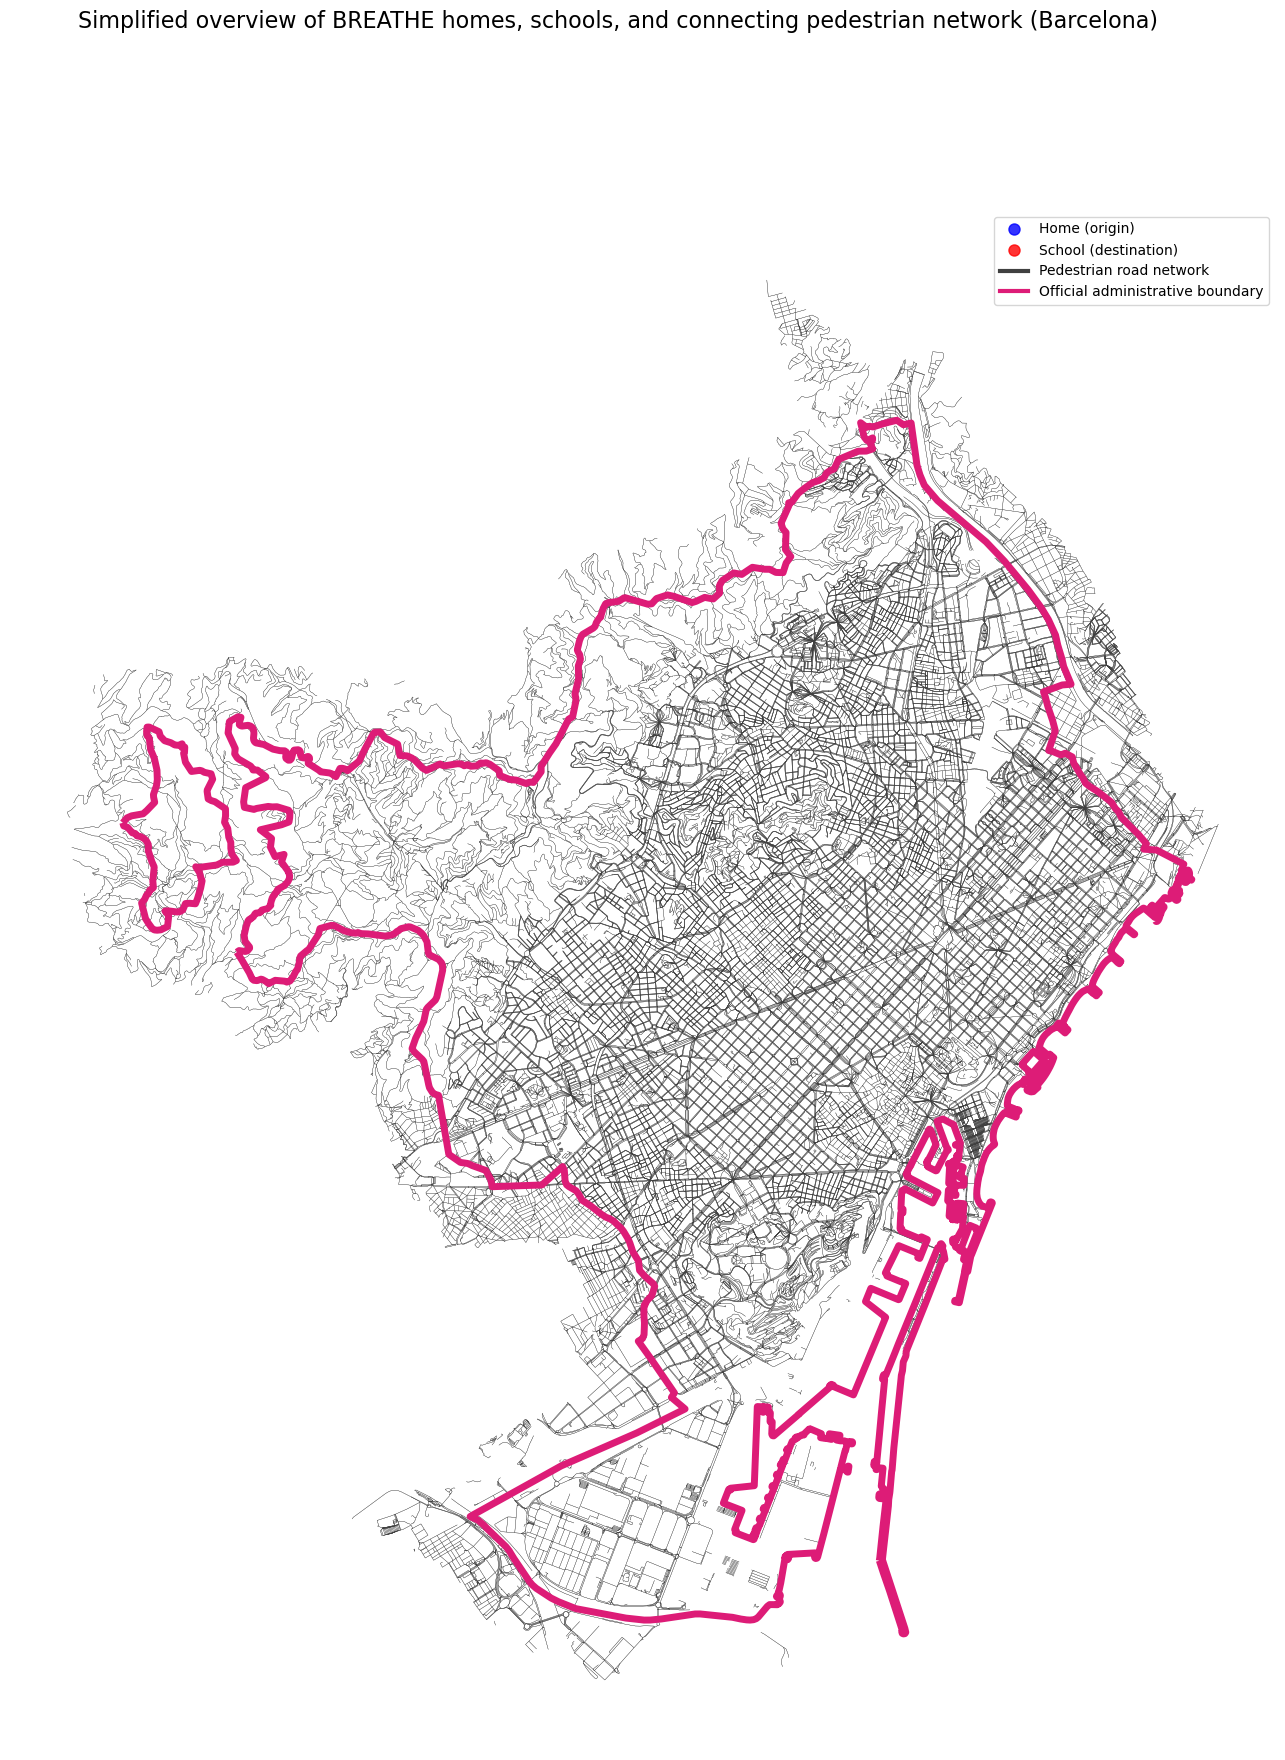

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('Simplified overview of BREATHE homes, schools, and connecting pedestrian network ({})'.format(place_name), fontsize=16)

paths_simpl.plot(ax=axs, color='#404040', linewidth=0.2, zorder=1)
# origins.plot(ax=axs, color='blue', alpha=0.3, zorder=2)
# destinations.plot(ax=axs, color='red', zorder=3)
place.plot(ax=axs, facecolor='None', edgecolor='#dd1c77', linewidth=5, zorder=4)

plt.legend(handles=input_legend_handles, loc='upper right')

plt.axis('off')

plt.show()

## Store intermediate output 

In [19]:
output_folder = os.path.join(folder, 'enriched')

In [20]:
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [21]:
output_file = os.path.join(output_folder, 'origins')
cols = ['X', 'Y']
origins[cols].to_csv(output_file+'.csv', sep='\t', index=False)
os.rename(output_file+'.csv', output_file+'.tsv')

In [22]:
output_file = os.path.join(output_folder, 'destinations')
cols = ['X', 'Y']
destinations[cols].to_csv(output_file+'.csv', sep='\t', index=False)
os.rename(output_file+'.csv', output_file+'.tsv')

In [23]:
output_file = os.path.join(output_folder, 'network_simpl{}.dxf'.format(simplification_tolerance))
paths_simpl.geometry.to_file(output_file, driver='DXF')

# Betweenness analysis in Rhino + UNA plug-in

We use the patronage betweenness method to calculate a heatmap of roads that may be used by children commuting to school by foot. Patronage betweenness calculates the paths between any origin (i.e. BREATHE homes) and destinations (i.e. BREATHE schools) via the street network (i.e. the Barcelona pedestrian network). 

It assumes that:
- children may walk to any school, as long as it lies within a threshold network distance (e.g. an 800m walk)
- but they are more likely to walk to schools that are close-by
- and they may take a slightly longer route than the absolute shortest one (e.g. up to 20% longer)

Instead of Python, we will use the software tool **Rhino** to run the analysis.

We will use the data we just preprocessed to run the patronage betweenness analysis. Manual steps to do so are elaborated on in the next cells.

**Software (one-time)**

- Download and install Rhino 6 on a **Windows** machine
- Install the Urban Network Analysis (UNA) toolbox plug-in in Rhino
    https://cityform.mit.edu/projects/una-rhino-toolbox

**Set-up Rhino project (one-time per school study/birth cohort)**

- start up Rhino 6 and open the .dxf file with the simplified road network, as created during the pre-processing
- [optionally] click the down arrow of the 'top' window to maximize the map view for overview
- open the layer tab in the window on the right, layer '0' contains the road network, you may rename it
- create a new layer named 'origins' and double click to activate it
- type the command **unaImportPoints** and hit enter
    - format=tsv
    - click file to select the origins .tsv file, as created during hte pre-processing
    - accept other values as default and hit enter
    - set X=X and Y=Y, and hit enter to load the data
- activitate the 'destinations' layer and repeat the **unaImportPoints** process to import the destinations
- [optionally] in the layer pane, give the three layers different colors, for overview
- [optionally] store the Rhino project to avoid repeating these steps in the future

**Run the analysis and store output**

input the following commands in Rhino 6:

- **unaAddNCurves**, then select the whole network, enter twice to build the network
- **unaAddPointOrigins**, then right mouse click origins layer (layer tab), select objects, enter twice
- **unaAddPointDestinations**, then right mouse click destinations layers, select objects, enter twice
- **unaPatronageBetweenness**, enter three times to accept the origins (blue) and destinations (red) and observers (none) we just selected
    - originsweights=count (i.e. every origin weights equally, because every origin represents one child)
    - destinationweights=count (i.e. every school also weights equally, because we do not know e.g. now large they are)
    - beta=0.002 (default)
    - alpha=14 (default)
    - applyelasticity=off (default)
    - detourratio=1.0 (i.e. only shortest trips and no detours; can also be set to up to 1.2 to allow trips that are up to 20% longer than their shortest path equivalent)
    - radius=800 (i.e. trips up to 800 meters)
    - and hit enter

If the analysis has successfully finished, Rhino shows the streets coloured according to the estimate number of children passing through, with the numbers shown as labels. To store the results:

- **unaExport**, then select everything
    - format=geojson
    - exporttype=file, with a name of choice, e.g. 'patrbetw_800_dr10.geojson'
    - epsg=2062 in the case of BREATHE, or another CRS EPSG code used as 'local_crs' variable in Python
    - set all other settings to 'include' to include all output information
    - and hit enter
    
Your results will be stored in a geojson file with your name of choice

These steps can be repeated with varying parameters, such as different radius distances and detour ratios. 

# Post-process and visualise results

In [24]:
style.use('dark_background')

In [25]:
value_col = '_Betweenness'
id_col = '__GUID'

In [26]:
# read the file resulting from the UNA analysis
filename = 'patrbetw_800_dr10.geojson'
patrbetw = gpd.read_file(os.path.join(folder, 'patronage_betweenness', filename))

In [27]:
patrbetw = patrbetw[patrbetw.geometry.type == 'LineString']
patrbetw.crs = local_crs
patrbetw[value_col] = patrbetw[value_col].astype(float)

# Visualise input data and results

In [28]:
quantiles = patrbetw[patrbetw[value_col]>0][value_col].quantile([0, 0.25, 0.5, 0.75, 1])

In [29]:
cmap = plt.cm.get_cmap('plasma')

In [30]:
# create legend
output_legend_handles = [
    mpatches.Patch(color='#404040', label='No commutes (0 children)'),
    mpatches.Patch(color=cmap(0.0), label='Few commutes (1 to {} children)'.format(int(round(quantiles[0.25])))),
    mpatches.Patch(color=cmap(0.5), label='Medium commutes ({} to {} children)'.format(int(round(quantiles[0.25])+1), int(round(quantiles[0.75])))),
    mpatches.Patch(color=cmap(1.0), label='Many commutes ({} to {} children)'.format(int(round(quantiles[0.75])+1), int(round(quantiles[1])))),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
]

Please note plotting of actual BREATHE home, school, and commuting route locations is commented out.

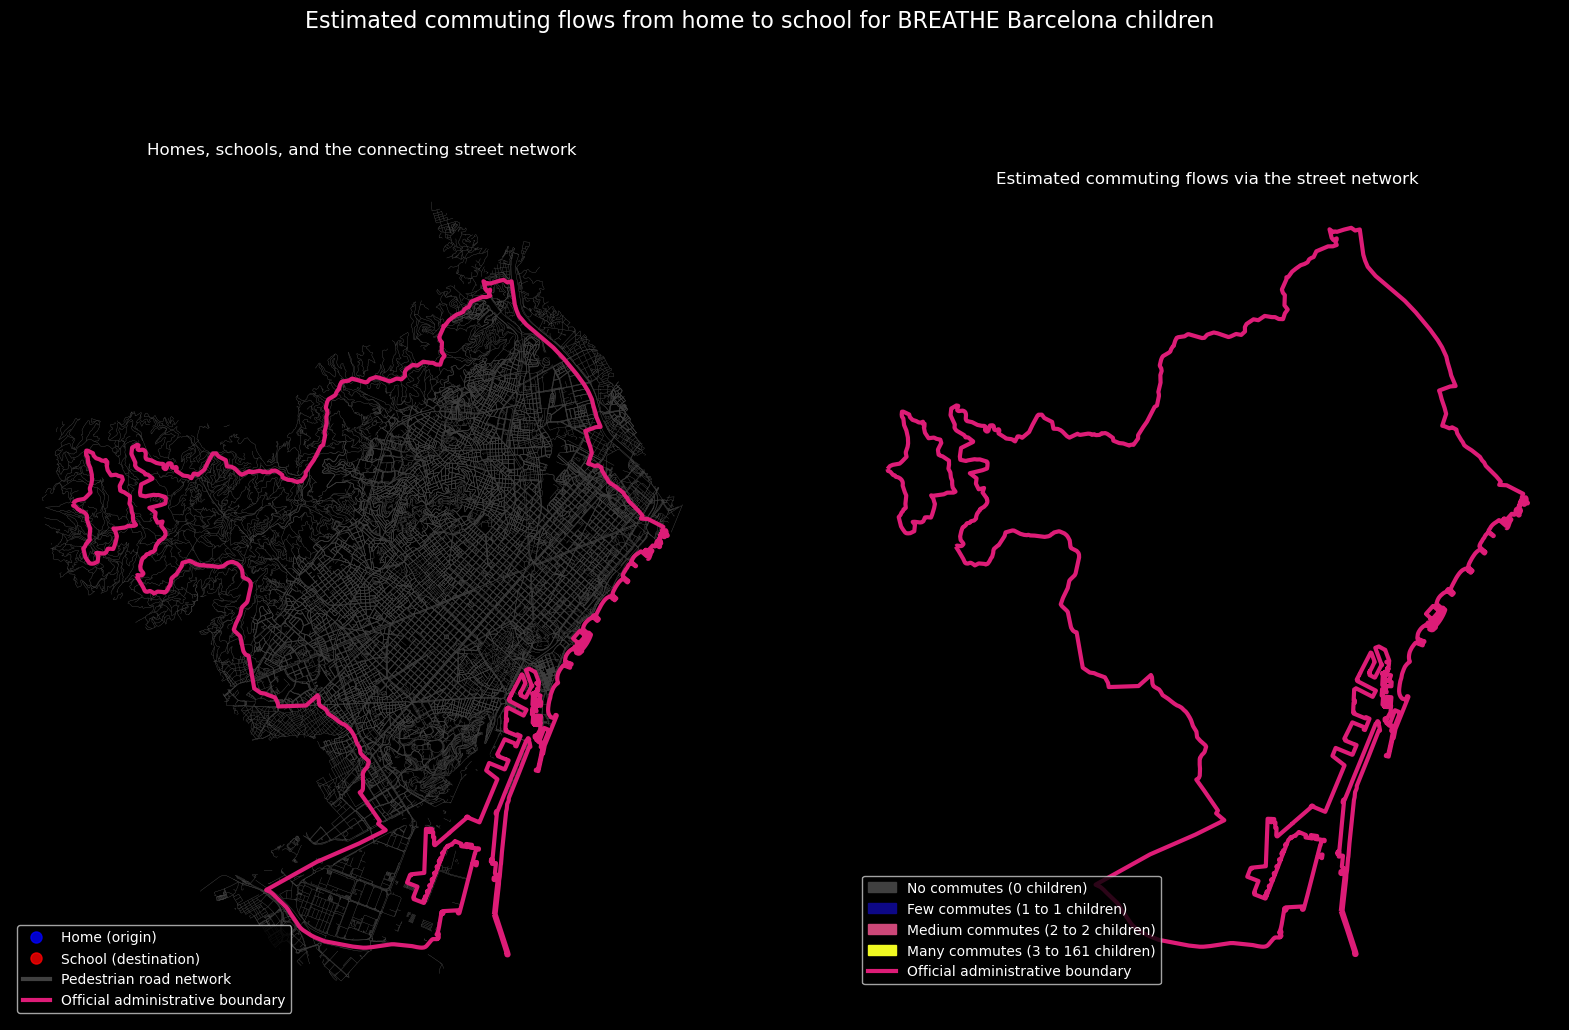

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
fig.suptitle('Estimated commuting flows from home to school for BREATHE Barcelona children', fontsize=16)

paths_simpl.plot(ax=axs[0], color='#404040', linewidth=0.2, zorder=1)
# origins.plot(ax=axs[0], color='blue', alpha=0.3, zorder=2)
# destinations.plot(ax=axs[0], color='red', zorder=3)
place.plot(ax=axs[0], facecolor='None', edgecolor='#dd1c77', linewidth=3, zorder=4)
axs[0].legend(handles=input_legend_handles, loc='lower left')
axs[0].set_title('Homes, schools, and the connecting street network')

# patrbetw[patrbetw[value_col]==0].plot(ax=axs[1], color='#404040', zorder=1, linewidth=0.2)
# patrbetw[patrbetw[value_col]>0].plot(ax=axs[1], column=value_col, cmap=cmap, scheme='quantiles', zorder=2, linewidth=0.5)
place.plot(ax=axs[1], facecolor='None', edgecolor='#dd1c77', linewidth=3, zorder=4)
axs[1].legend(handles=output_legend_handles, loc='lower left')
axs[1].set_title('Estimated commuting flows via the street network')

axs[0].axis('off')
axs[1].axis('off')

plt.show()